# Logistic Regression

Objectives:
1. Define a classification problem
2. Understand why linear regression does not fit to solve classification problem
3. Understand logistic function
4. Demonstrate the cost function
5. Apply gradient descent with logistic function

### Supervised learning 
   - => Regression 
   - => Classification: 
      - Logistic Regression (Binary classifier)

In [62]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from class_utils.lab_utils_common import dlc, plot_data, draw_vthresh, sigmoid
from class_utils.plt_one_addpt_onclick import plt_one_addpt_onclick
from class_utils.plt_logistic_loss import  plt_logistic_cost, plt_two_logistic_loss_curves, plt_simple_example
from class_utils.plt_logistic_loss import soup_bowl, plt_logistic_squared_error

# %matplotlib widget 
# %matplotlib notebook
%matplotlib inline
plt.style.use('../Style/deeplearning.mplstyle')

In [63]:
cancer_dataset = pd.read_csv('../Datasets/cancer.csv')
cancer_dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84358402,M,20.29,14.34,135.1,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.2,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
4,844359,M,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.1127,0.07400,...,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN


In [64]:
cancer_dataset = cancer_dataset[['area_mean','diagnosis']]
cancer_dataset.head()

,area_mean,diagnosis
0,1001.0,M
1,1326.0,M
2,1203.0,M
3,1297.0,M
4,1040.0,M


In [65]:
cancer_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area_mean  473 non-null    float64
 1   diagnosis  473 non-null    object 
dtypes: float64(1), object(1)
memory usage: 7.5+ KB


# Data Preprocessing

In [66]:
numerical_cols = cancer_dataset.select_dtypes(include='number').columns
categorical_cols = cancer_dataset.select_dtypes(include='object').columns

In [67]:
min = cancer_dataset[numerical_cols].min()
max = cancer_dataset[numerical_cols].max()

In [68]:
"""
x = (x - min_x) / (max_x - min_x)
x [0, 1]
"""

cancer_dataset[numerical_cols] = (cancer_dataset[numerical_cols] - min) / (max -min)
cancer_dataset[categorical_cols] = cancer_dataset[categorical_cols].apply(lambda col:  pd.Categorical(col).codes)
cancer_dataset.head()


,area_mean,diagnosis
0,0.363733,1
1,0.501591,1
2,0.449417,1
3,0.489290,1
4,0.380276,1


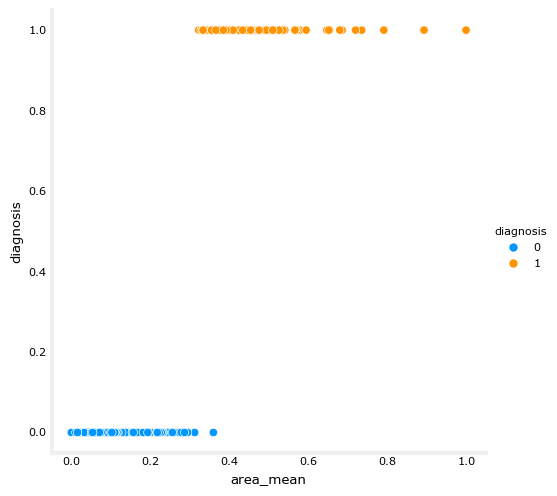

In [69]:
sns.relplot(
    data=cancer_dataset,
    x="area_mean",
    y="diagnosis",
    hue="diagnosis",
)

# Split Dataset

In [70]:
seed = 142
np.random.seed(seed)

In [71]:
def split_dataset(dataset, training_ratio=0.6, val_ratio=0.2):
    no_of_examples = len(dataset)
    
    random_indices = np.random.permutation(no_of_examples)
    
    train_size = int(no_of_examples * training_ratio)
    val_size = int(no_of_examples * val_ratio)
    
    train_indices = random_indices[:train_size]
    val_indices = random_indices[train_size:train_size + val_size]
    test_indices = random_indices[train_size + val_size:]
    
    train_ds = dataset.iloc[train_indices]
    val_ds = dataset.iloc[val_indices]
    test_ds = dataset.iloc[test_indices]
    
    train_X = np.array(train_ds.iloc[:, :-1])
    train_y = np.array(train_ds.iloc[:, -1])
    val_X = np.array(val_ds.iloc[:, :-1])
    val_y = np.array(val_ds.iloc[:, -1])
    test_X = np.array(test_ds.iloc[:, :-1])
    test_y = np.array(test_ds.iloc[:, -1])
    
    return train_X, train_y, val_X, val_y, test_X, test_y
    
train_X, train_y, val_X, val_y, test_X, test_y = split_dataset(cancer_dataset)

AttributeError: 'CheckButtons' object has no attribute 'rectangles'

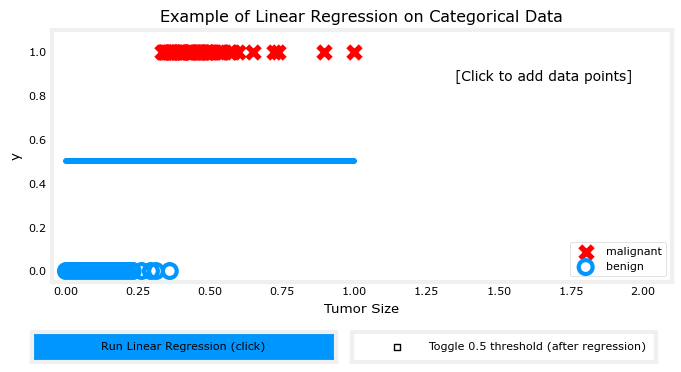

In [72]:
"""
z = w * x + b
"""

w = np.zeros(1)
b = 0
plt.close('all') 
__ = plt_one_addpt_onclick(train_X, train_y, w, b, logistic=False)

# Logistic Function

In [ ]:
z = np.arange(-10, 11)
g = 1 / (1 + np.exp(-z))

print(f"z={z}, g={g}")

z=[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10], g=[4.54e-05 1.23e-04 3.35e-04 9.11e-04 2.47e-03 6.69e-03 1.80e-02 4.74e-02
 1.19e-01 2.69e-01 5.00e-01 7.31e-01 8.81e-01 9.53e-01 9.82e-01 9.93e-01
 9.98e-01 9.99e-01 1.00e+00 1.00e+00 1.00e+00]


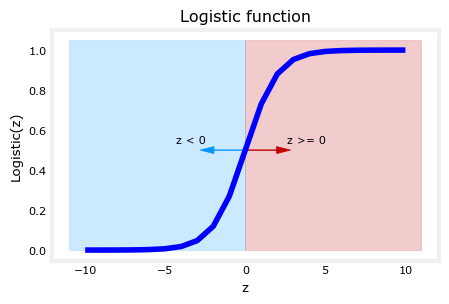

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(z, g, c="b")
    
ax.set_title("Logistic function")
ax.set_ylabel('Logistic(z)')
ax.set_xlabel('z')
draw_vthresh(ax,0)

In [ ]:
"""
when z >= 0, g >= 0.5
when z < 0, g < 0.5

g is always in between [0, 1]
probability is also in between [0, 1]
"""

"""
What is the probability of input x to be a malignant class
For example: If get_cancer_class_prob returns 0.4
It means, the P(M | x; w, b) = 0.4
We know, P(B|x; w, b) + P(M|x; w, b) = 1
So, P(B|x; w, b) = 1 - P(M|x; w, b)
                 = 1 - 0.4
                 = 0.6

So, P(B|x; w, b) > P(M|x; w, b), this is classified as benign
Otherwise malignant class
"""

"""
y_true = [0, 1, 1, 0, 0]
y_pred = [0.3, 0.8, 0.9, 0.5, 0.6]

mse = (0-0.3)^2 + (1-0.8)^2 + (1-0.9)^2 + (0-0.5)^2 + (0-0.6)^2
mse = mse / 10
"""
def get_cancer_class_prob(x, w, b):
    z = w * x + b
    y_prob = 1 / (1 + np.exp(-z))
    return y_prob

AttributeError: 'CheckButtons' object has no attribute 'rectangles'

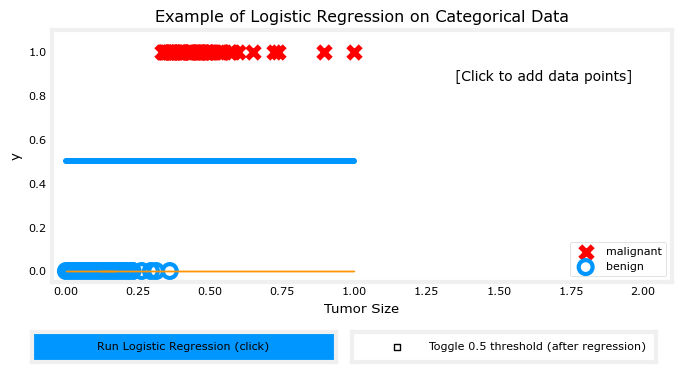

In [ ]:
plt.close('all') 
__ = plt_one_addpt_onclick(train_X, train_y, w, b, logistic=True)

# Cost function
### Linear regression : Mean Squared Error
- train_X, train_y
- train_y_pred = get_house_prediction(train_X, train_y, w, b)
- mse = np.mean((train_y - train_y_pred) ** 2) / 2


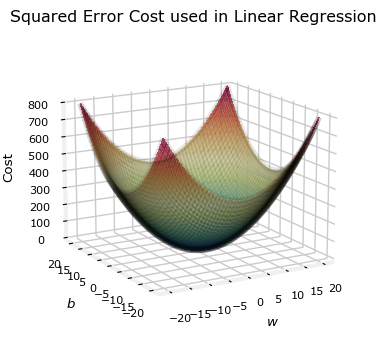

In [ ]:
soup_bowl()

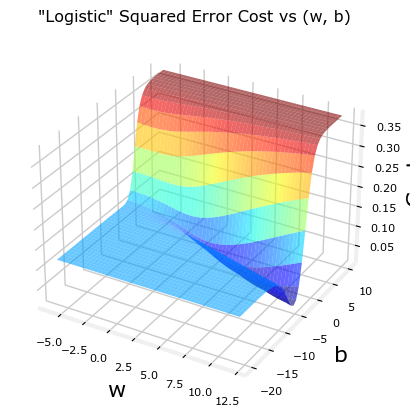

In [ ]:
plt.close('all')
plt_logistic_squared_error(train_X, train_y)
plt.show()

# Cost: Logistic Loss / Binary Cross Entropy Loss

log_loss = y_true * log(y_pred) - (1 - y_true) * log(1 - y_pred)

y_true = 1, log_loss = log(y_pred)
- => If y_pred = 1, log_loss = 0 (No penalty)
- => If y_pred = 0, log_loss = INF (Heavy penalty)
  
y_true = 0, log_loss = -log(1 - y_pred)
-  => If y_pred = 0, log_loss = 0 (No penalty)
-  => If y_pred = 1, log_loss = INF (Heavy penalty)

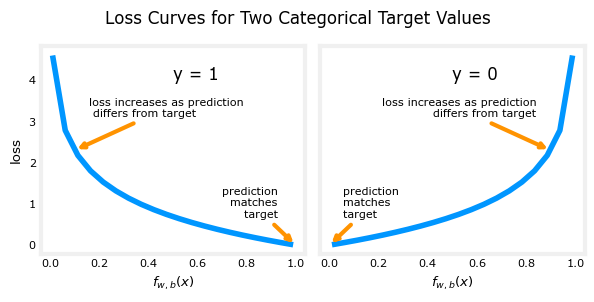

In [ ]:

plt.close('all')
plt_two_logistic_loss_curves()

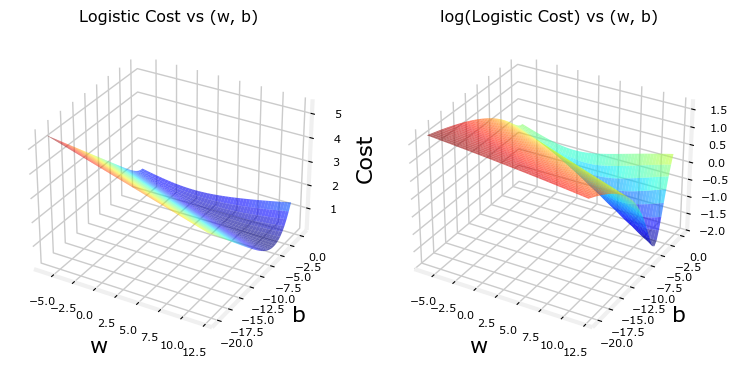

In [ ]:
plt.close('all')
cst = plt_logistic_cost(train_X, train_y)

In [ ]:

"""
cost: When you calculate the loss on entire training set
loss: For an example
"""
def cost_function(X, y, w, b):
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        y_pred = get_cancer_class_prob(X[i], w, b)
        log_loss = -y[i]*np.log(y_pred) - (1-y[i])*np.log(1-y_pred)
        cost += log_loss
             
    cost = cost / m
    return cost[0]

log_loss = cost_function(train_X, train_y, w, b)
print(f"Log loss is {log_loss}  (Parameters not learned yet.)")

Log loss is 0.6931471805599466  (Parameters not learned yet.)


# Gradient Descent
- Compute cost (done)
- Compute gradients
- Update parameters

In [ ]:

def compute_gradient(X, y_true, w, b):
    delta = 1e-9
    cost_1 = cost_function(X, y_true, w, b)
    cost_2 = cost_function(X, y_true, w + delta, b)
    cost_3 = cost_function(X, y_true, w, b + delta)
    dw = (cost_2 - cost_1) / delta
    db = (cost_3 - cost_1) / delta
    return dw, db

In [ ]:
""" 
In each epoch there are forward propagation and backward propagation
forward propagation: Compute logits, gradients
backward propagation: Update the parameters

Understand the idea of callbacks:
1. Early stopping
2. Model checkpoint
"""

THRESHOLD = 0.5

def train_model(train_X, train_y, val_X, val_y, epochs=10000, lr=0.001):
    """ Initialize parameters """
    w = np.random.randint(0, 10, 1)
    b = 0
    
    for epoch in range(epochs):
        """ Compute gradients """
        dw, db = compute_gradient(train_X, train_y, w, b)
        
        """ Update parameters """
        w = w - lr * dw
        b = b - lr * db
        
        if epoch % 1000 == 0:
            """ Compute logits / loss """
            loss = cost_function(train_X, train_y, w, b)
            val_loss = cost_function(val_X, val_y, w, b)
            print(f"epoch:{epoch}/{epochs}, loss:{loss:.3f}, val_loss:{val_loss:0.3f}")
    
    return w, b

w, b = train_model(train_X, train_y, val_X, val_y)
print("Weight:", w, "bias:", b)

epoch:0/10000, loss:0.904, val_loss:0.918
epoch:1000/10000, loss:0.692, val_loss:0.710
epoch:2000/10000, loss:0.552, val_loss:0.572
epoch:3000/10000, loss:0.461, val_loss:0.483
epoch:4000/10000, loss:0.402, val_loss:0.426
epoch:5000/10000, loss:0.364, val_loss:0.389
epoch:6000/10000, loss:0.339, val_loss:0.365
epoch:7000/10000, loss:0.322, val_loss:0.350
epoch:8000/10000, loss:0.311, val_loss:0.339
epoch:9000/10000, loss:0.303, val_loss:0.332
Weight: [5.87] bias: -2.122650529678971


# Evaluate

In [ ]:
test_loss = cost_function(test_X, test_y, w, b)
print(f"log_loss is {test_loss}")

log_loss is 0.30898241616146493


# Evaluation metric: Accuracy

In [ ]:

y_pred_train = get_cancer_class_prob(train_X, w, b)
y_pred_train = np.where(y_pred_train >= THRESHOLD, 1, 0)

train_acc = 0
for i in range(len(y_pred_train)):
    if y_pred_train[i] == train_y[i]:
        train_acc += 1
train_acc = train_acc / len(y_pred_train) * 100.0

y_pred_test = get_cancer_class_prob(test_X, w, b)
y_pred_test = np.where(y_pred_test >= THRESHOLD, 1, 0)

test_acc = 0
for i in range(len(y_pred_test)):
    if y_pred_test[i] == test_y[i]:
        test_acc += 1
train_acc = test_acc / len(y_pred_test) * 100.0

print(f"Train accuracy: {train_acc:0.2f}%")
print(f"test accuracy: {test_acc:0.2f}%")

Train accuracy: 94.79%
test accuracy: 91.00%
